In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import models
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

from sklearn.metrics import classification_report, roc_auc_score
import seaborn as sns

import pandas as pd
import numpy as np

import random
import pickle
import time

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, update_display
import cv2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**IMPORTANT: due to huge dataset size, this toggle represents whether the dataset is present and accessible to the machine.**

**This means that if set to False, training/val/test loops will not run**

In [18]:
ACCESS_TO_DATASET = False

# TRANSFORMS, DATASETS, DATALOADERS

In [3]:
size = (400, 400)

transform_identity = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_augment = transforms.Compose([
    transforms.Resize(size),
    
    # minor data augmentations
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)), # small rotation+translation+zoom, i.e. patient positional variance
    transforms.RandomAutocontrast(p=0.3), 
    transforms.Lambda(lambda x: F.adjust_gamma(x, random.uniform(0.8, 1.2))),  # gamma, i.e. exposure variation
    
    transforms.ToTensor(),
    
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01 * x.max()), # 0.5 noise    
    
    transforms.Normalize(mean=[0.5], std=[0.5])
])

sanity check:

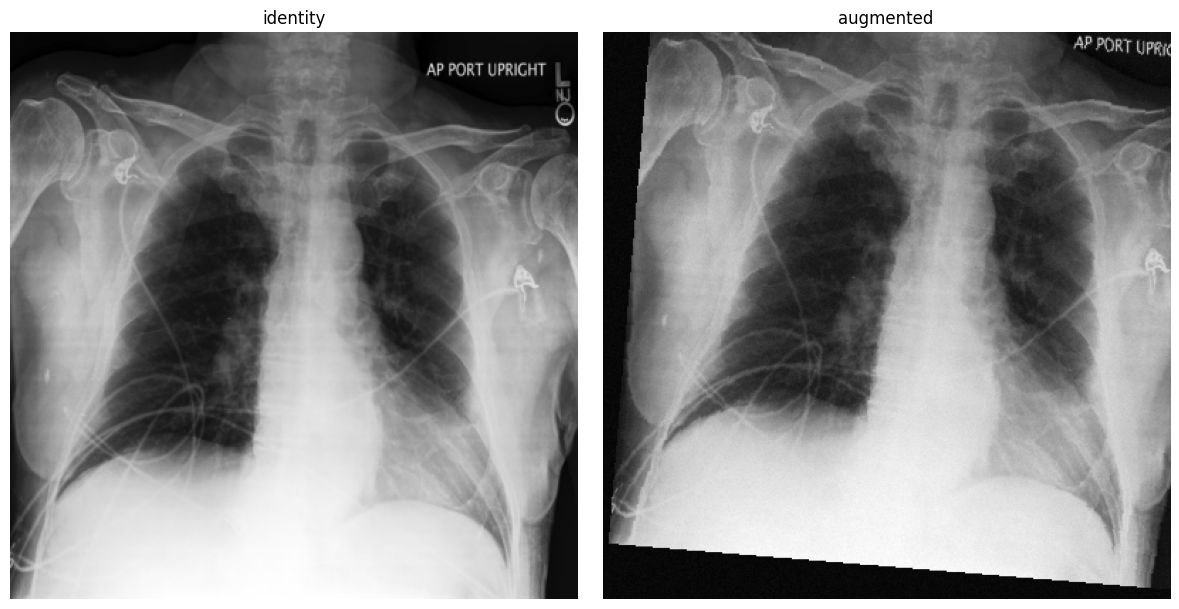

In [4]:
img = Image.open("patient64541_xray_positive_1-2-3.jpg") 

img_identity = transform_identity(img)  
img_augmented = transform_augment(img) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(img_identity[0], cmap='gray')
ax1.set_title('identity')
ax1.axis('off')
ax2.imshow(img_augmented[0], cmap='gray')
ax2.set_title('augmented')
ax2.axis('off')
plt.tight_layout()
plt.show()

In [6]:
BATCHSIZE = 32

class CheXpertDataset(Dataset):
    def __init__(self, csv_path, image_root, transform, start_index):
        """
        Args:
            csv_path (str): Path to test_labels.csv
            image_root (str): Root directory for images (e.g., 'test/')
            transform (callable): transform to be applied
        """
        self.labels_df = pd.read_csv(csv_path)
        self.image_root = image_root
        self.transform = transform
        self.start_index = start_index

        self.classes = self.labels_df.columns.tolist()[start_index:] # extract the class names 
        
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        img_path = self.labels_df.iloc[idx, 0]  # First column is 'Path'
        image = Image.open(f"{self.image_root}/{img_path}")
        image = self.transform(image)
        
        labels = self.labels_df.iloc[idx, self.start_index:].astype(np.float32).values
        labels = torch.from_numpy(labels).float()
                    
        return image, labels, img_path  


train_dataset = CheXpertDataset(
    # csv_path=".\\datasets\\chexpertchestxrays-u20210408\\train_visualCheXbert_SMALL.csv",
    csv_path=".\\datasets\\chexpertchestxrays-u20210408\\train_visualCheXbert.csv",
    image_root=".\\datasets\\chexpertchestxrays-u20210408", 
    transform=transform_augment,
    start_index=5
)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCHSIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

val_dataset = CheXpertDataset(
    csv_path=".\\datasets\\chexlocalize_test_val\\CheXpert\\val_labels.csv",
    image_root=".\\datasets\\chexlocalize_test_val\\CheXpert", 
    transform=transform_identity,
    start_index=5
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCHSIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_dataset = CheXpertDataset(
    csv_path=".\\datasets\\chexlocalize_test_val\\CheXpert\\test_labels.csv",
    image_root=".\\datasets\\chexlocalize_test_val\\CheXpert", 
    transform=transform_identity,
    start_index=1
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCHSIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)
    
# Test single batches:
images, labels, paths = next(iter(train_loader))
print(f"Batch shape: {images.shape} Labels shape: {labels.shape}")  # Should be [B, 1, (size)], [B, 14]

images, labels, paths = next(iter(val_loader))
print(f"Batch shape: {images.shape} Labels shape: {labels.shape}")  # Should be [B, 1, (size)], [B, 14]

images, labels, paths = next(iter(test_loader))
print(f"Batch shape: {images.shape} Labels shape: {labels.shape}")  # Should be [B, 1, (size)], [B, 14]

if (train_dataset.classes == val_dataset.classes and val_dataset.classes == test_dataset.classes): 
    print("Column headers match")
    idx_to_class_name = train_dataset.classes
else:
    print("beeg problem")

Batch shape: torch.Size([32, 1, 400, 400]) Labels shape: torch.Size([32, 14])
Batch shape: torch.Size([32, 1, 400, 400]) Labels shape: torch.Size([32, 14])
Batch shape: torch.Size([32, 1, 400, 400]) Labels shape: torch.Size([32, 14])
Column headers match


# MODEL

In [7]:

class CheXpertResNet50(nn.Module):
    def __init__(self, pretrained=True, num_classes=14):
        super().__init__()
        backbone = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
        
        # Replace the first conv to accept 1 channel
        # Keep the original weights by summing across the RGB channels
        w = backbone.conv1.weight.data
        # w shape: (64, 3, 7, 7) -> average or sum to (64,1,7,7)
        w_gray = w.sum(dim=1, keepdim=True)  # sum RGB→gray
        new_conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=backbone.conv1.out_channels,
            kernel_size=backbone.conv1.kernel_size,
            stride=backbone.conv1.stride,
            padding=backbone.conv1.padding,
            bias=backbone.conv1.bias is not None
        )
        new_conv1.weight.data.copy_(w_gray)
        if backbone.conv1.bias is not None:
            new_conv1.bias.data.copy_(backbone.conv1.bias.data)

        # remaining operations until layer4
        self.features = nn.Sequential(
            new_conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
            backbone.layer1,
            backbone.layer2,
            backbone.layer3,
            backbone.layer4,
        )

        # 4. Global pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))

        # 5. Classifier head
        self.classifier = nn.Sequential(
            nn.Flatten(),                 
            nn.Dropout(p=0.2),            
            nn.Linear(backbone.layer4[-1].conv3.out_channels, num_classes),
            # nn.Sigmoid() removed for ###################################################
        )

        ### CAM STUFF
        # expose layer4[-1] for CAM hooks
        self.gradcam_target = backbone.layer4[-1]

        self.activations = None
        self.gradients   = None
        def forward_hook(module, inp, out): # out's shape (B, C, H', W')
            self.activations = out.detach()
        def backward_hook(module, grad_in, grad_out): # grad_out[0]'s shape same as activations
            self.gradients = grad_out[0].detach()
        self.gradcam_target.register_forward_hook(forward_hook)
        self.gradcam_target.register_full_backward_hook(backward_hook)

    def forward(self, x):
        """
        x: (B, 1, H, W) grayscale images
        """
        x = self.features(x)            # -> (B, 2048, h', w')
        # self.activations = x            # for Grad-CAM
        x = self.global_pool(x)         # -> (B, 2048, 1, 1)
        x = self.classifier(x)          # -> (B, 14)
        return x


In [19]:
model = CheXpertResNet50()
model.to(device)
if ACCESS_TO_DATASET == False:
    model.load_state_dict(torch.load("e2_chexpert_resnet152.sav", map_location=device))

# CAM STUFF 

In [10]:
HEATMAP_THRESHOLD = 0.2
BOX_LINE_WIDTH = 5
CENTER_RADIUS = 10
CAM_OPACITY = 0.25

# ─── compute_gradcam ──────────────────────────────────────────────
def compute_gradcam(model, input_tensor, class_idx):
    """
    model: CheXpertResNet50 with hooks
    input_tensor: shape (1,1,H,W)
    class_idx: int
    """
    # 1) Forward
    logits = model(input_tensor)              # (1,14)
    # 2) Zero grads & backward from target logit
    model.zero_grad()
    logits[0, class_idx].backward(retain_graph=True)

    # 3) Grab from model
    activations = model.activations           # (1, C, h', w')
    gradients   = model.gradients             # (1, C, h', w')

    # 4) Compute weights αᶜₖ
    weights = gradients.mean(dim=[0,2,3], keepdim=True)  # (1,C,1,1)

    # 5) Weighted combination & ReLU
    cam = torch.nn.functional.relu((weights * activations).sum(dim=1)).squeeze()  # (h',w')
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    return cam.cpu().numpy()

# ─── extract_bbox_and_center ──────────────────────────────────────
def extract_bbox_and_center(cam, threshold=HEATMAP_THRESHOLD):
    """
    cam: HxW numpy array normalized [0,1]
    returns: bbox=(x0,y0,x1,y1), center=(cx,cy) in cam coords or (None,None)
    """
    mask = (cam >= threshold).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
    if num_labels <= 1:
        return None, None
    areas = stats[1:, cv2.CC_STAT_AREA]
    idx = areas.argmax() + 1
    x, y, w, h, _ = stats[idx]
    ys, xs = np.where(labels == idx)
    cx, cy = xs.mean(), ys.mean()
    return (x, y, x+w, y+h), (cx, cy)

# ─── overlay_heatmap_on_image ────────────────────────────────────
def overlay_heatmap_on_image(orig_pil, cam):
    """
    orig_pil: PIL.Image in grayscale (mode 'L')
    cam: (h', w') numpy array in [0,1]
    returns: PIL.Image with heatmap overlay
    """
    orig_np = np.array(orig_pil)  # shape (H, W)

    # Convert grayscale to 3-channel RGB
    if len(orig_np.shape) == 2:
        orig_np = np.stack([orig_np]*3, axis=-1)  # -> (H, W, 3)

    H, W = orig_np.shape[:2]
    cam_resized = cv2.resize(cam, (W, H))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

    # Blend
    overlay = (heatmap * CAM_OPACITY + orig_np * (1 - CAM_OPACITY)).astype(np.uint8)
    return Image.fromarray(overlay)


# ─── visualize_cam_for_class ─────────────────────────────────────
# def visualize_cam_for_class(model, orig_pil, input_tensor, class_idx, class_name=None, score=None):
#     """
#     Runs Grad-CAM for a single class on one image, returns:
#       - overlayed heatmap PIL.Image
#       - boxed PIL.Image (bbox + center + label)
#     """
#     # 1) compute CAM
#     cam = compute_gradcam(model, input_tensor, class_idx)

#     # 2) heatmap overlay
#     heatmap_img = overlay_heatmap_on_image(orig_pil, cam)

#     # 3) draw bbox + center + label on original
#     # boxed = orig_pil.copy()
#     boxed = orig_pil.convert("RGB").copy()
#     draw = ImageDraw.Draw(boxed)
#     font = ImageFont.load_default()
#     W, H = boxed.size

#     # resize cam to image size
#     cam_resized = cv2.resize(cam, (W, H))
#     bbox, center = extract_bbox_and_center(cam_resized)
#     if bbox is not None:
#         x0, y0, x1, y1 = bbox
#         cx, cy = center
#         # box & center
#         draw.rectangle([x0,y0,x1,y1], outline="red", width=BOX_LINE_WIDTH)
#         draw.ellipse([cx-CENTER_RADIUS, cy-CENTER_RADIUS,
#                       cx+CENTER_RADIUS, cy+CENTER_RADIUS],
#                      fill="red")
#         # label
#         label = f"{class_name or class_idx}{' '+f'{score:.2f}' if score is not None else ''}"
#         # measure
#         tb = draw.textbbox((0,0), label, font=font)
#         tw, th = tb[2]-tb[0], tb[3]-tb[1]
#         tx = min(max(cx + 10, 0), W - tw)
#         ty = min(max(cy - th/2, 0), H - th)
#         draw.rectangle([tx, ty, tx+tw, ty+th], fill="black")
#         draw.text((tx, ty), label, fill="yellow", font=font)

#     return heatmap_img, boxed

def visualize_cam_for_class(model, orig_pil, input_tensor, class_idx, class_name=None, score=None):
    """
    Compute and visualize Grad-CAM for a class index.
    Returns: overlayed heatmap with bounding box and label drawn ON TOP.
    """
    # 1. Compute CAM
    cam = compute_gradcam(model, input_tensor, class_idx)

    # 2. Convert grayscale to RGB base for drawing
    orig_np = np.array(orig_pil)
    if len(orig_np.shape) == 2:
        orig_np = np.stack([orig_np]*3, axis=-1)  # (H, W, 3)

    H, W = orig_np.shape[:2]
    cam_resized = cv2.resize(cam, (W, H))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    overlay = (heatmap * CAM_OPACITY + orig_np * (1 - CAM_OPACITY)).astype(np.uint8)

    # 3. Create PIL image and draw
    combined = Image.fromarray(overlay).convert("RGB")
    draw = ImageDraw.Draw(combined)
    font = ImageFont.load_default()

    bbox, center = extract_bbox_and_center(cam_resized)
    if bbox is not None:
        x0, y0, x1, y1 = bbox
        cx, cy = center
        draw.rectangle([x0, y0, x1, y1], outline="purple", width=BOX_LINE_WIDTH)
        draw.ellipse([cx - CENTER_RADIUS, cy - CENTER_RADIUS,
                      cx + CENTER_RADIUS, cy + CENTER_RADIUS], fill="yellow")

        label = f"{class_name or class_idx}{' '+f'{score:.2f}' if score is not None else ''}"
        tb = draw.textbbox((0, 0), label, font=font)
        tw, th = tb[2] - tb[0], tb[3] - tb[1]
        tx = min(max(cx + 10, 0), W - tw)
        ty = min(max(cy - th / 2, 0), H - th)
        draw.rectangle([tx, ty, tx + tw, ty + th], fill="black")
        draw.text((tx, ty), label, fill="yellow", font=font)

    return combined



# RUN THE MODEL : TRAIN / TEST LOOP

In [9]:
# model(images).shape


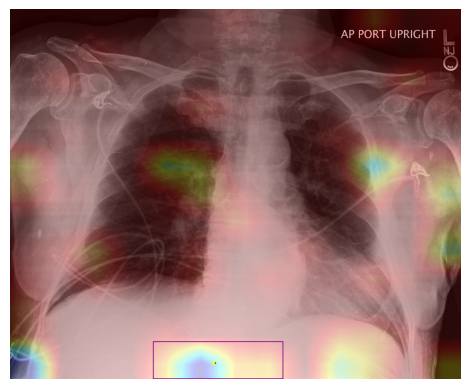

class is:  Cardiomegaly


In [22]:
# UNTRAINED MODEL 
boxed_heatmap = visualize_cam_for_class(
    model = CheXpertResNet50().to(device), # use a random init model
    orig_pil=img, 
    input_tensor=transform_augment(img).unsqueeze(0).to(device) , 
    class_idx=2 
)
plt.imshow(boxed_heatmap)
plt.axis('off')
plt.show()
print('class is: ', idx_to_class_name[2])

CHEXPERT PAPER:Images are fed into the network with
size 320 × 320 pixels. We use the Adam optimizer with de-
fault β-parameters of β1 = 0.9, β2 = 0.999 and learning
rate 1 × 10−4 which is fixed for the duration of the training.
Batches are sampled using a fixed batch size of 16 images.
We train for 3 epochs, saving checkpoints every 4800 itera-
tions.

### handle metrics

In [17]:
train_losses, val_losses = [], []
train_accs, val_accs     = [], []
train_aurocs, val_aurocs = [], []

## train / val helpers

In [27]:
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    iteration = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} Train", leave=False)
    for images, labels, _ in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(images) # shape [B,14]
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        # accumulate
        running_loss += loss.item() * images.size(0)
        probs = torch.sigmoid(logits).detach().cpu()
        preds = (probs >= 0.5).int()
        
        all_preds.append(preds)
        all_labels.append(labels.cpu().int())
        
        pbar.set_postfix(loss=loss.item())
    
    # epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    epoch_acc = (all_preds == all_labels).float().mean().item()
    
    try:
        # Get probabilities from preds (already thresholded), or recompute from logits
        probs = all_preds.float()  # or re-run sigmoid on stored logits if you want
        epoch_auroc = np.mean([
            roc_auc_score(all_labels[:, i].numpy(), probs[:, i].numpy())
            for i in range(all_labels.shape[1])
            if len(torch.unique(all_labels[:, i])) > 1
        ])
    except ValueError:
        epoch_auroc = 0.0  # fallback if no variability
    
    return epoch_loss, epoch_acc, epoch_auroc

@torch.no_grad()
def evaluate(epoch, loader=val_loader, verbose=True):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    
    pbar = tqdm(val_loader, desc=f"Epoch {epoch} Val", leave=False)
    for images, labels, _ in pbar:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        
        running_loss += loss.item() * images.size(0)
        probs = torch.sigmoid(logits).cpu()
        preds = (probs >= 0.5).int()
        
        all_preds.append(preds)
        all_labels.append(labels.cpu().int())
        all_probs.append(probs)
    
    epoch_loss = running_loss / len(val_loader.dataset)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_probs = torch.cat(all_probs)

    per_class_acc = (all_preds == all_labels).float().mean(dim=0) 
    print(per_class_acc)
    epoch_acc = (all_preds == all_labels).float().mean().item()

    # === AUROC ===
    # per-class AUROC, then mean
    aurocs = []
    for i in range(all_labels.shape[1]):
        if len(torch.unique(all_labels[:,i]))>1:
            aurocs.append(roc_auc_score(all_labels[:,i].numpy(), all_probs[:,i].numpy()))
    epoch_auroc = float(np.mean(aurocs)) if aurocs else 0.0

    if verbose:
        print('per class aurocs', aurocs ) # can extract per class aurocs here
        print("\nClassification Report (per class):")
        print(classification_report(
            all_labels.numpy(),
            all_preds.numpy(),
            target_names=idx_to_class_name,
            zero_division=0  # to avoid warnings for classes with no positive preds
        ))
    
    return epoch_loss, epoch_acc, epoch_auroc

## actually run the model

**DO NOT RUN BELOW IF NO DATASET**

In [26]:
criterion = nn.BCEWithLogitsLoss()  # model outputs logits
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=1e-5)

In [24]:
this code block should error, as a safeguard against running all cells

SyntaxError: invalid syntax (1806626478.py, line 1)

In [14]:
num_epochs = 3
start_time = time.time()

if ACCESS_TO_DATASET:

    for epoch in range(1, num_epochs+1): # MAIN TRAIN LOOP
        
        epoch_start = time.time()
        
        tr_loss, tr_acc, tr_auroc = train_one_epoch(epoch)
        val_loss, val_acc, val_auroc = evaluate(epoch)
        
        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        train_aurocs.append(tr_auroc)
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_aurocs.append(val_auroc)
    
        # Time tracking
        total_elapsed = time.time() - start_time
        eta = (num_epochs - epoch) * (time.time() - epoch_start) # epochs remaining * epoch_duration
        # Convert time in seconds to mm:ss
        def format_time(t):
            m, s = divmod(int(t), 60)
            return f"{m:02d}:{s:02d}"
        
        print(f"Epoch {epoch} | Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.4f}, AUROC: {tr_auroc:.4f} "
              f"| Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUROC: {val_auroc:.4f}")
        print(f"Elapsed: {format_time(total_elapsed)} | ETA: {format_time(eta)}")

        torch.save(model.state_dict(), f"e{epoch}_chexpert_resnet152.sav")
    
    model.eval() # just in case
    
    print()

tensor([0.9060, 0.7350, 0.7393, 0.8248, 0.9103, 0.8205, 0.7650, 0.9103, 0.7949,
        0.8547, 0.8632, 0.9786, 0.8547, 0.7735])
per class aurocs [np.float64(0.9509935553168636), np.float64(0.8376513761467891), np.float64(0.8055457122608081), np.float64(0.9086566725455614), np.float64(0.6824034334763949), np.float64(0.9065255731922398), np.float64(0.9169304990200513), np.float64(0.8545353982300885), np.float64(0.8808441558441559), np.float64(0.7859513274336283), np.float64(0.922602556081866), np.float64(0.5236051502145922), np.float64(0.9395098977113842)]

Classification Report (per class):
                            precision    recall  f1-score   support

                No Finding       0.70      0.74      0.72        38
Enlarged Cardiomediastinum       0.67      0.84      0.75       109
              Cardiomegaly       0.54      0.76      0.63        68
              Lung Opacity       0.81      0.89      0.85       126
               Lung Lesion       0.00      0.00      0.00    

tensor([0.9017, 0.7607, 0.7393, 0.8376, 0.9487, 0.8632, 0.8205, 0.9274, 0.8120,
        0.9188, 0.8675, 0.9872, 0.8675, 0.8846])
per class aurocs [np.float64(0.9538131041890441), np.float64(0.8456513761467891), np.float64(0.8130758327427356), np.float64(0.9122574955908289), np.float64(0.6781115879828326), np.float64(0.9174603174603174), np.float64(0.907432534298206), np.float64(0.810287610619469), np.float64(0.8982142857142857), np.float64(0.8136061946902655), np.float64(0.9211725802127089), np.float64(0.3819742489270386), np.float64(0.9596732651409228)]

Classification Report (per class):
                            precision    recall  f1-score   support

                No Finding       0.64      0.92      0.75        38
Enlarged Cardiomediastinum       0.71      0.82      0.76       109
              Cardiomegaly       0.54      0.74      0.62        68
              Lung Opacity       0.85      0.84      0.85       126
               Lung Lesion       0.00      0.00      0.00     

tensor([0.8889, 0.7436, 0.7265, 0.8590, 0.9444, 0.8632, 0.7863, 0.8974, 0.8419,
        0.9444, 0.8547, 0.9316, 0.7735, 0.8974])
per class aurocs [np.float64(0.9564983888292159), np.float64(0.8388256880733946), np.float64(0.7965095676824946), np.float64(0.930408583186361), np.float64(0.7253218884120172), np.float64(0.9153439153439153), np.float64(0.9146690788481834), np.float64(0.8633849557522124), np.float64(0.9051136363636364), np.float64(0.8396017699115045), np.float64(0.9230494235409777), np.float64(0.8326180257510729), np.float64(0.9556994628007948)]

Classification Report (per class):
                            precision    recall  f1-score   support

                No Finding       0.60      0.97      0.74        38
Enlarged Cardiomediastinum       0.71      0.75      0.73       109
              Cardiomegaly       0.52      0.69      0.59        68
              Lung Opacity       0.87      0.87      0.87       126
               Lung Lesion       0.00      0.00      0.00    

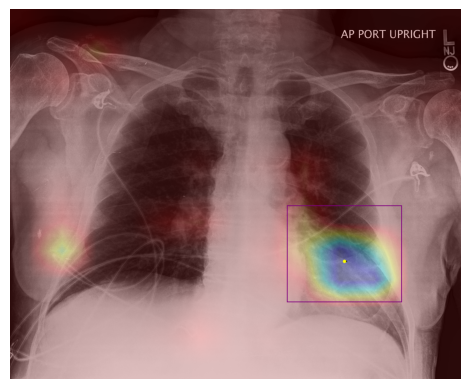

tensor([[0.2209, 0.4440, 0.2838, 0.3233, 0.0392, 0.1207, 0.0794, 0.0545, 0.1958,
         0.0487, 0.0938, 0.0525, 0.2423, 0.3491]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [30]:
# img = Image.open("patient64541_xray_positive_1-2-3.jpg") 
boxed_heatmap = visualize_cam_for_class(
    model, 
    orig_pil=img, 
    input_tensor=transform_identity(img).unsqueeze(0).to(device) , 
    class_idx=2 # 5 is edema
)
plt.imshow(boxed_heatmap)
plt.axis('off')
plt.show()

torch.sigmoid(model(transform_identity(img).unsqueeze(0).to(device)))

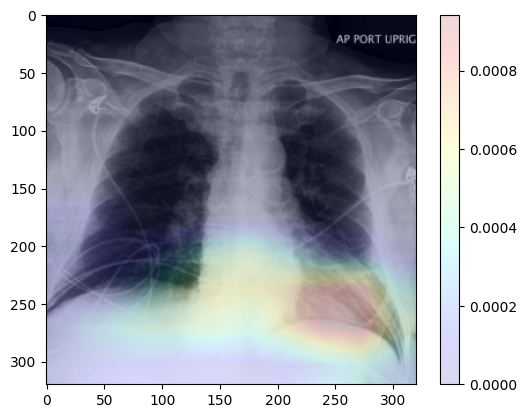

In [33]:
# COMPARE TO VAL 
# Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity # 1 2 3 respectively
if ACCESS_TO_DATASET: # my local machine paths
    path1="datasets/chexlocalize_test_val/CheXlocalize/gradcam_maps_val/patient64541_study1_view1_frontal_Enlarged Cardiomediastinum_map.pkl"
    path2="datasets/chexlocalize_test_val/CheXlocalize/gradcam_maps_val/patient64541_study1_view1_frontal_Cardiomegaly_map.pkl"
    path3="datasets/chexlocalize_test_val/CheXlocalize/gradcam_maps_val/patient64541_study1_view1_frontal_Airspace Opacity_map.pkl"
else: # submission paths
    path1="portable_dataset_folder/patient64541_study1_view1_frontal_Enlarged Cardiomediastinum_map.pkl"
    path2="portable_dataset_folder/patient64541_study1_view1_frontal_Cardiomegaly_map.pkl"
    path3="portable_dataset_folder/patient64541_study1_view1_frontal_Airspace Opacity_map.pkl"

# FIX THIS
with open("datasets/chexlocalize_test_val/CheXlocalize/gradcam_maps_val/patient64541_study1_view1_frontal_Support Devices_map.pkl", "rb") as f:
    pkl = pickle.load(f)
    cxr_img = pkl['cxr_img'].permute(1, 2, 0)
    heatmap = pkl['map'].squeeze()

plt.imshow(cxr_img, cmap="gray")
plt.imshow(heatmap, cmap="jet", alpha=0.15) 

plt.colorbar()
plt.show()

In [49]:
@torch.no_grad()
def suitable_name_here(loader):
    model.eval()

    all_labels = []
    all_preds = []
    
    # for images, labels, _ in loader:
    for images, labels, _ in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        # loss = criterion(logits, labels)
        
        # running_loss += loss.item() * images.size(0)
        preds = torch.sigmoid(logits).cpu()
        labels = labels.cpu()

        all_preds.append(preds)
        all_labels.append(labels)

    # Stack everything
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return all_preds, all_labels

def class_analysis(all_preds, all_labels, class_idx, savefig=False, savepath=""):
    # Extract specific class
    y_true = all_labels[:, class_idx]
    y_prob = all_preds[:, class_idx]

    # Create a DataFrame for easy plotting
    # Create DataFrame and ensure label is int (for palette keys)
    df = pd.DataFrame({
        'True Label': y_true.int(),
        'Predicted Prob': y_prob
    })

    # Plotting
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    sns.violinplot(x='True Label', y='Predicted Prob', data=df, inner=None, linewidth=0, hue='True Label', 
                   palette={0: 'red', 1: 'blue'}, legend=False, ax=ax, alpha=0.2)
    sns.scatterplot(data=df, x='True Label', y='Predicted Prob', alpha=0.2, edgecolor=None, ax=ax)

    ax.set_title(f"Prediction Vs True for {class_name or f'Class {class_idx}'}")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['True = 0', 'True = 1'])
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True)
    plt.tight_layout()
    if savefig:
        plt.savefig(f"comp_label_pred_{savepath}.png")
    plt.show()
    

In [33]:
preds, labels = suitable_name_here(
    test_loader,
)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.09it/s]


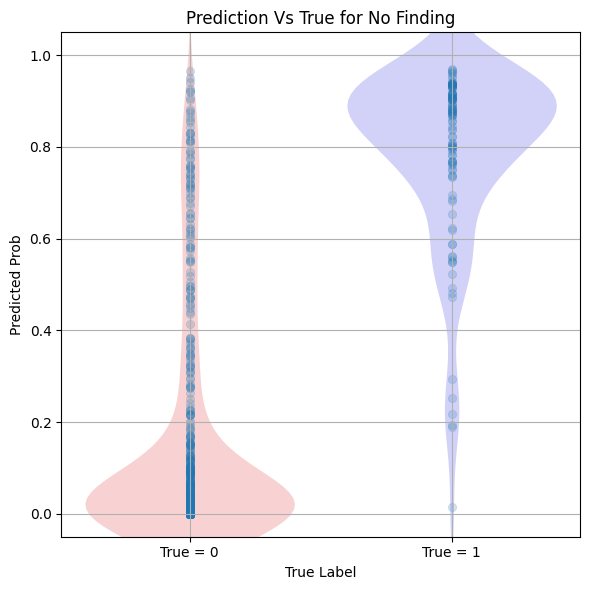

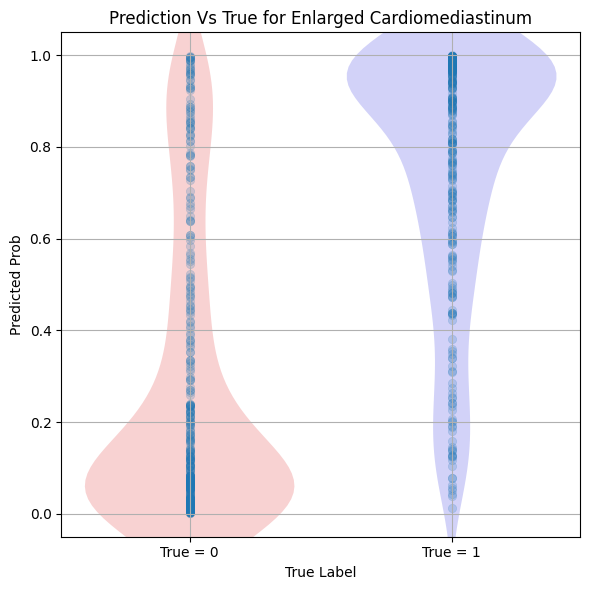

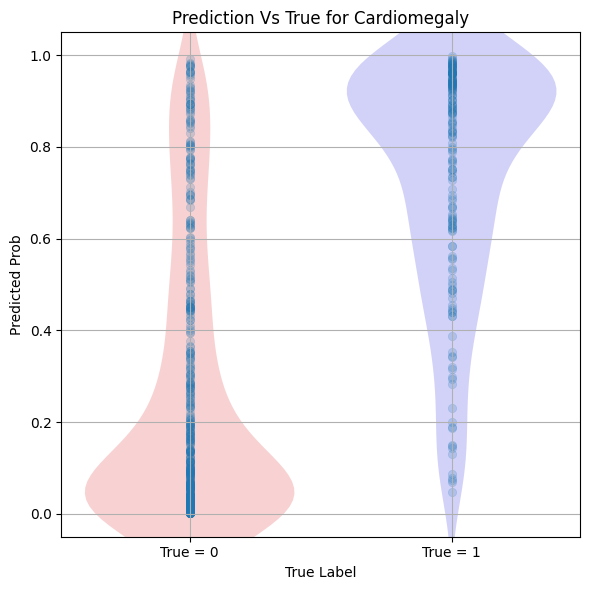

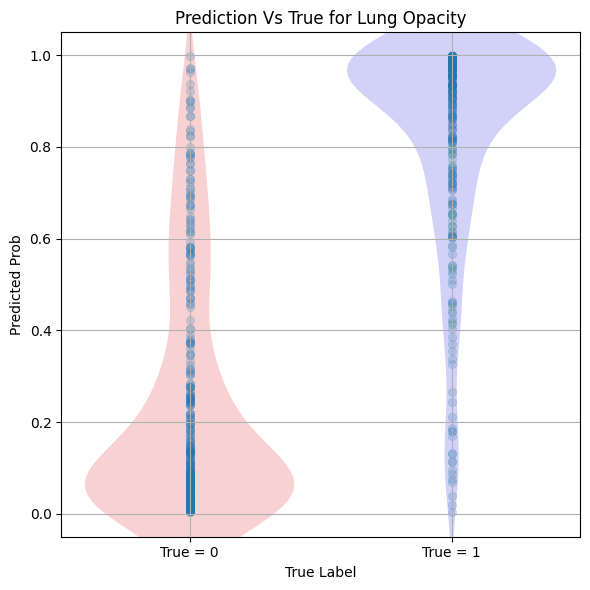

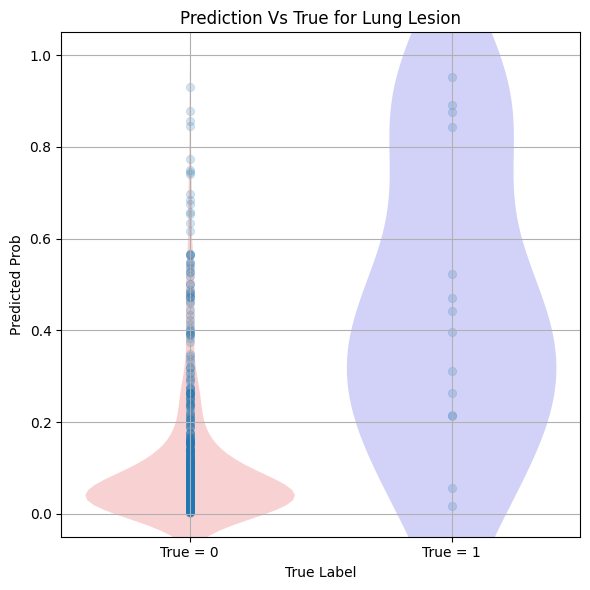

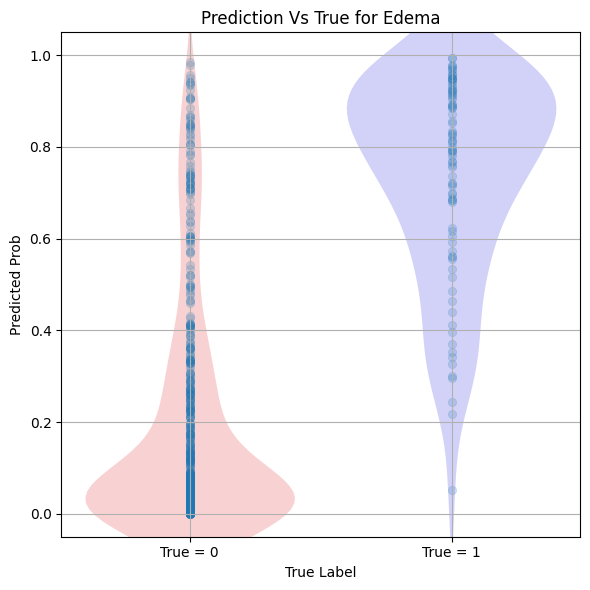

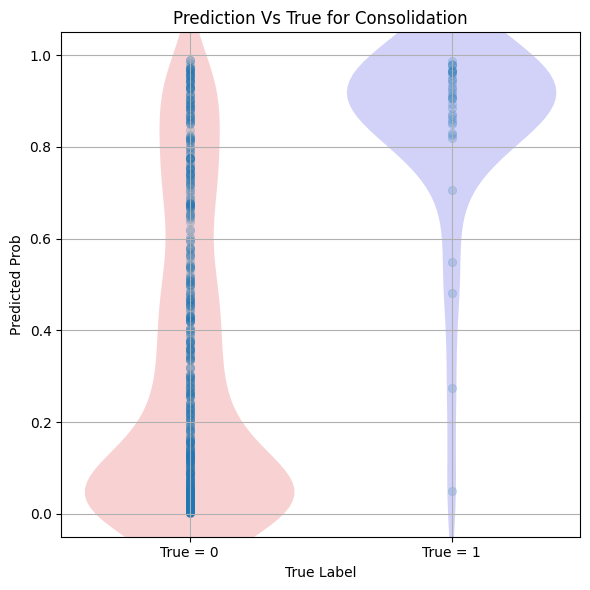

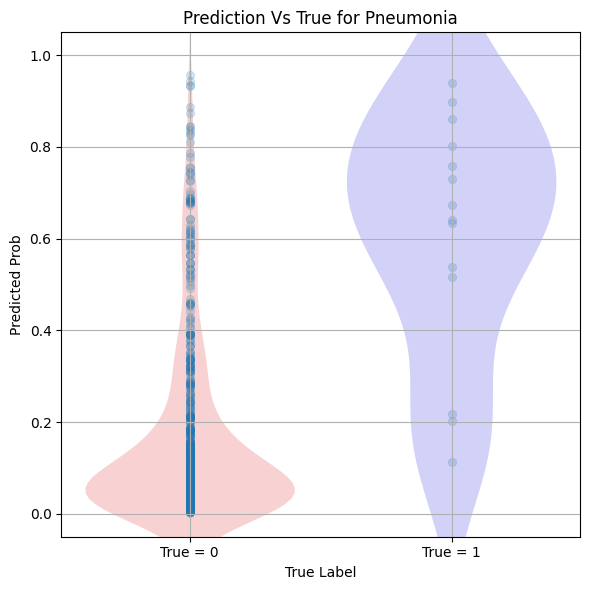

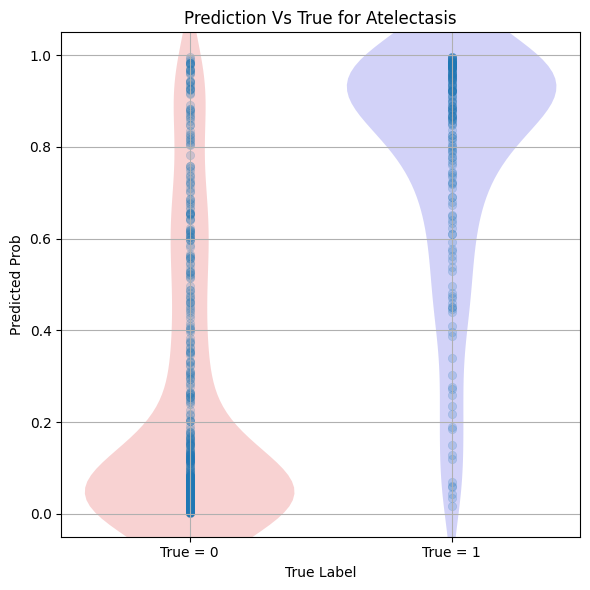

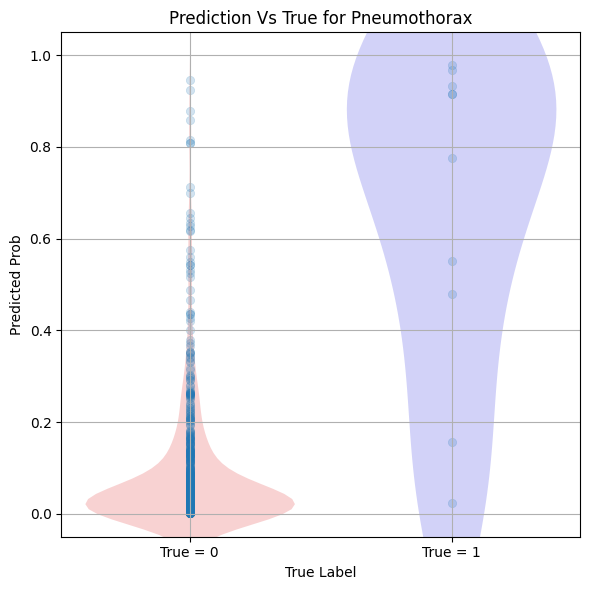

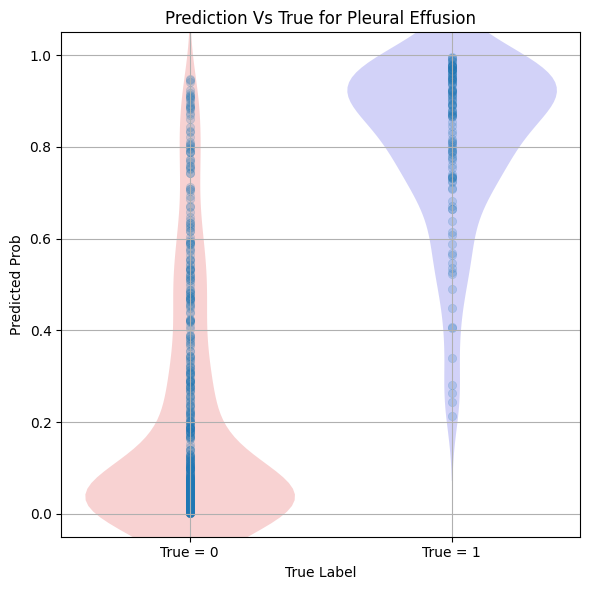

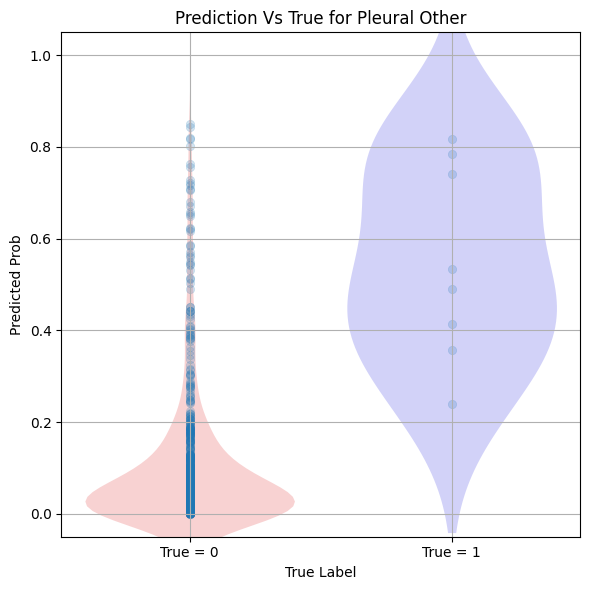

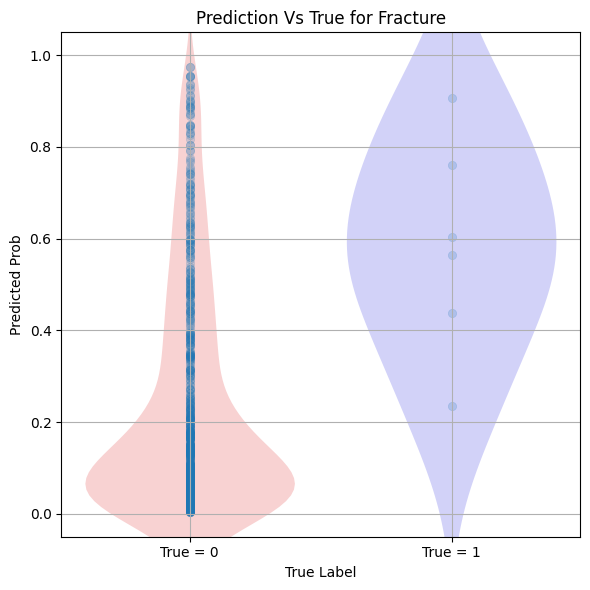

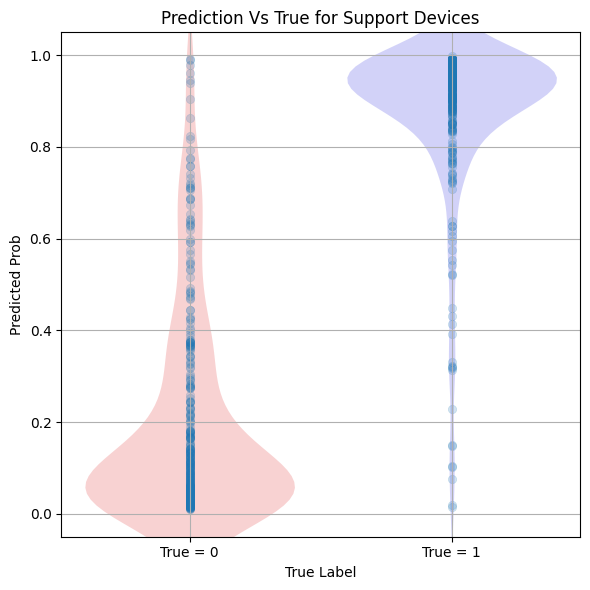

In [50]:
for class_idx in range(len(test_dataset.classes)):
    class_name = test_dataset.classes[class_idx]
    class_analysis(preds, labels, class_idx=class_idx, savefig=True, savepath=class_name)
# 13 8 10 0 2 3 5 6 

In [ ]:
# train
# val
# test val
# test test